# MNIST in TensorFlow Lite Micro

# Python Modules

In [1]:
import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten

# modules for plotting in this notebook
import numpy as np
import matplotlib.pyplot as plt
import random

Make sure we're on the right TensorFlow version

# Loading MNIST Data

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# 60,000 training data and 10,000 test data of 28x28 pixel images
print("x_train shape", x_train.shape)
print("y_train shape", y_train.shape)
print("x_test shape", x_test.shape)
print("y_test shape", y_test.shape)

11490434/11490434 [==============================] - 0s 0us/step
x_train shape (60000, 28, 28)
y_train shape (60000,)
x_test shape (10000, 28, 28)
y_test shape (10000,)


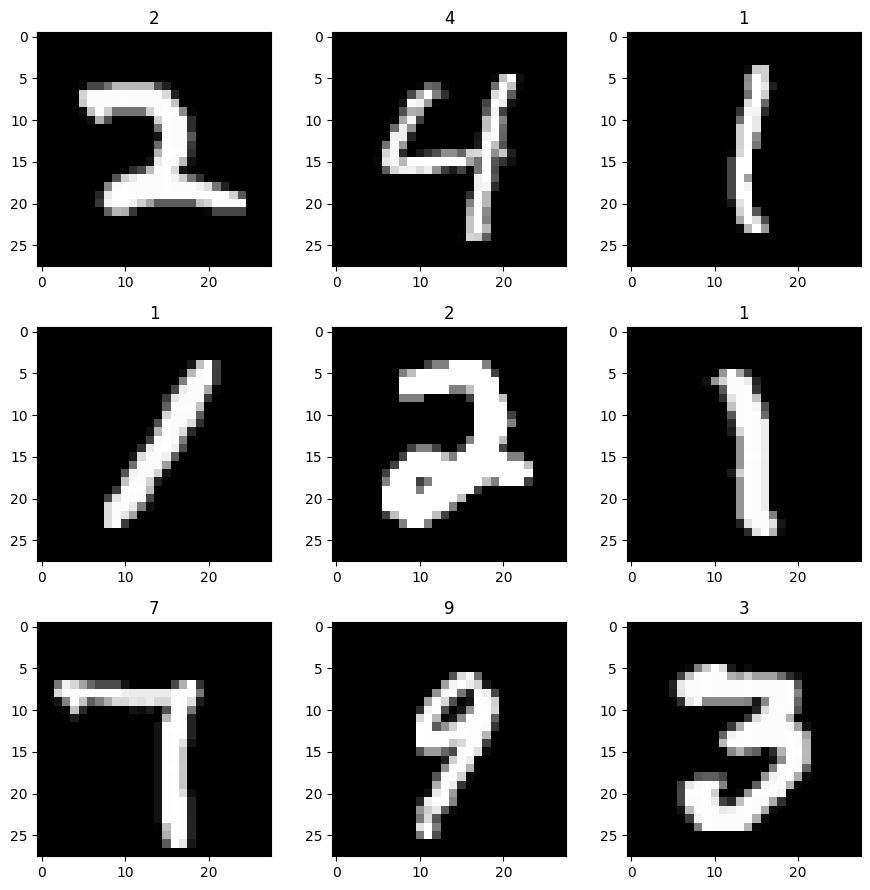

In [3]:
fig = plt.figure(figsize=(9,9))

for i in range(9):
  plt.subplot(3,3,i+1)
  num = random.randint(0, len(x_train))
  plt.imshow(x_train[num], cmap="gray", interpolation=None)
  plt.title(y_train[num])

plt.tight_layout()

# Setup Test Split (For representative dataset)

In [4]:
x_train = x_train.reshape(60000, 28*28)
x_test = x_test.reshape(10000, 28*28)
x_train = x_train.astype("float32")
x_test = x_test.astype("float32")
x_train /= 255
x_test /= 255

y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

print("x_train shape", x_train.shape)
print("y_train shape", y_train.shape)

x_train shape (60000, 784)
y_train shape (60000, 10)


# Convert Given Model to .TFLite (Full 8Bit enforcement) [PTQ TFLite](https://www.tensorflow.org/lite/performance/post_training_quantization)

In [6]:
model= tf.keras.models.load_model('/content/Full_Precision_MNIST_TF.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 6)         156       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 6)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 16)        2416      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 16)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 120)               9

# PTQ provides ~90% smaller model

In [8]:
x_test = x_test.reshape((-1, 28, 28, 1))

mnist_sampleset = tf.data.Dataset.from_tensor_slices((x_test)).batch(1)

def representative_dataset_gen():
    for input_value in mnist_sampleset.take(100):
        yield [input_value]

# Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8  # or tf.uint8
converter.inference_output_type = tf.int8  # or tf.uint8
tflite_quant_model = converter.convert()

# Save the model
open("model.tflite", "wb").write(tflite_quant_model)


/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


112920

# Test TFLite Model (Almost same accuracy as bigger model)

In [ ]:
import numpy as np
import tensorflow as tf

# Load the TensorFlow Lite model
interpreter = tf.lite.Interpreter(model_path="model.tflite")

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Prepare the test data
# Assuming x_test is your test dataset
# Make sure x_test is of shape (num_samples, 28, 28, 1) for MNIST
x_test = x_test.reshape((-1, 28, 28, 1))

# Ensure the output tensor has the correct shape (num_samples, 10)
interpreter.resize_tensor_input(input_details[0]["index"], (10000, 28, 28, 1))
interpreter.resize_tensor_input(output_details[0]["index"], (10000, 10))
interpreter.allocate_tensors()

# Update input and output details after resizing tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Set the test input and run the interpreter
interpreter.set_tensor(input_details[0]["index"], x_test)
interpreter.invoke()

# Get the result and check its accuracy
output_data = interpreter.get_tensor(output_details[0]["index"])

# Assuming y_test is your true labels
a = [np.argmax(y, axis=None, out=None) for y in output_data]
b = [np.argmax(y, axis=None, out=None) for y in y_test]

accuracy = (np.array(a) == np.array(b)).mean()
print("TFLite Accuracy:", accuracy)


TFLite Accuracy: 0.9851


# Save .TFLite as C Array

In [ ]:
import binascii

def convert_to_c_array(bytes) -> str:
  hexstr = binascii.hexlify(bytes).decode("UTF-8")
  hexstr = hexstr.upper()
  array = ["0x" + hexstr[i:i + 2] for i in range(0, len(hexstr), 2)]
  array = [array[i:i+10] for i in range(0, len(array), 10)]
  return ",\n  ".join([", ".join(e) for e in array])

tflite_binary = open("model.tflite", 'rb').read()
ascii_bytes = convert_to_c_array(tflite_binary)
c_file = "const unsigned char tf_model[] = {\n  " + ascii_bytes + "\n};\nunsigned int tf_model_len = " + str(len(tflite_binary)) + ";"
# print(c_file)
open("model8bit.h", "w").write(c_file)

2693626